In [1]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random
from tqdm import trange

In [2]:
DEV = "cuda:0" if torch.cuda.is_available() else "cpu"
DEV = torch.device(DEV)
DEV

device(type='cuda', index=0)

## Load data

In [3]:
!wget https://raw.githubusercontent.com/ncarkaci/TDKDictionaryCrawler/master/ortak_kelimeler.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
with open("ortak_kelimeler.txt", encoding='utf-8') as f:
    text = f.read()

In [5]:
words = text.split("\n")

In [6]:
long_text = text.replace("\n","")
ids = list(set(long_text))
len(ids)

29

In [7]:
ordinal_char_pairs = sorted([(ord(c),c) for c in ids])
ordinal_char_pairs

[(97, 'a'),
 (98, 'b'),
 (99, 'c'),
 (100, 'd'),
 (101, 'e'),
 (102, 'f'),
 (103, 'g'),
 (104, 'h'),
 (105, 'i'),
 (106, 'j'),
 (107, 'k'),
 (108, 'l'),
 (109, 'm'),
 (110, 'n'),
 (111, 'o'),
 (112, 'p'),
 (114, 'r'),
 (115, 's'),
 (116, 't'),
 (117, 'u'),
 (118, 'v'),
 (121, 'y'),
 (122, 'z'),
 (231, 'ç'),
 (246, 'ö'),
 (252, 'ü'),
 (287, 'ğ'),
 (305, 'ı'),
 (351, 'ş')]

In [8]:
len(ordinal_char_pairs)

29

## Encode & Decode Functions

In [9]:
ctoi = {c:i for i,(o,c) in enumerate(ordinal_char_pairs)}
itoc =  {i:c for i,(o,c) in enumerate(ordinal_char_pairs)}

In [10]:
ctoi['.']=len(ctoi)
itoc[len(itoc)]='.'

In [11]:
def encode(input:str):
    return [ctoi[c] for c in input]

def decode(ids):
    return "".join([itoc[i] for i in ids])

In [12]:
assert decode(encode("zemberek"))=='zemberek'

## Helpers

In [13]:
def plot_training_loss(nn):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))


    axs[0].plot(nn.losses, label="Neural net train loss")
    axs[0].plot(nn.val_losses, label="Neural net val loss")
    axs[0].set_title('Losses')
    axs[0].legend()

    axs[1].plot([g[1] for g in nn.grads], label="Max")
    axs[1].plot([g[0] for g in nn.grads], label="Min")
    axs[1].plot([g[2] for g in nn.grads], label="Avg")
    axs[1].set_title('Gradients')
    axs[1].legend()

    plt.show()

In [14]:
def lr_search(nn, xs, ys, steps=1001):
        lre = torch.linspace(-3, 0, steps)
        lrs = 10**lre

        lri = []
        for i in trange(steps):
            lr = lrs[i]
            
            nn.train(xs, ys, lr = lr, steps=1)
            
            lri.append(lre[i])

        plt.plot(lri, nn.losses)

## Prepare Training Data

In [15]:
def generate_data(words, block_size):
    xs, ys = [], []
    for w in words:
        context = [ctoi["."]]*block_size
        for c in w+'.':
            id = ctoi[c]

            xs.append(context)
            ys.append(id)

            context = context[1:]+[id]

    print(f"Generated {len(xs)} samples")

    xs = torch.tensor(xs, device=DEV)
    ys = torch.tensor(ys, device=DEV)

    return xs, ys

In [16]:
random.seed(13)
random.shuffle(words)

n = len(words)
n1 = int(n*0.8)
n2 = int(n*0.9)

## Train

In [17]:
class MlpLM:
    def __init__(self, block_size, n_embd, hidden_size=100):

        self.block_size = block_size
        self.n_embd = n_embd
        self.hidden_size = hidden_size

        self.g = torch.Generator(device=DEV).manual_seed(13)

        self.C = torch.randn((30, self.n_embd), generator=self.g, device=DEV)
        self.W1 = torch.randn((self.n_embd*self.block_size, hidden_size), generator=self.g, device=DEV)
        self.b1 = torch.randn(hidden_size, generator=self.g, device=DEV)
        self.W2 = torch.randn((hidden_size, 30), generator=self.g, device=DEV)
        self.b2 = torch.randn(30, generator=self.g, device=DEV)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

        for p in self.parameters:
            p.requires_grad = True
        
        # for logging
        self.losses = []
        self.val_losses = []
        self.grads = []

    def forward(self, ix):
        assert len(ix.shape) == 2
        assert ix.shape[1] == self.block_size, f"Input shape: {ix.shape}, block size: {self.block_size}"
        batch_size = ix.shape[0]

        if ix.device!=DEV: ix = ix.to(DEV)

        # 1- embeddings
        embd = self.C[ix].float()
        embd = embd.view(-1, self.block_size * self.n_embd)
        assert embd.shape == (batch_size, self.block_size * self.n_embd)
        assert embd.device == DEV
        
        # 2- hidden layer
        h = torch.tanh(embd@self.W1 + self.b1)
        assert h.shape == (batch_size, self.hidden_size)

        logits = h@self.W2 + self.b2
        assert logits.shape == (batch_size, 30)

        return logits
    

    def train(self, xs, ys, xval=None, yval=None, lr=0.1, steps=1001, batch_size=None, print_steps=10):
        assert xs.device == self.C.device

        if steps>1:
            print(f"Model has {sum([p.nelement() for p in self.parameters])} parameters!")
            print(f"Using {len(xs)} samples")

        # set default loss value to zero
        loss = val_loss = torch.zeros((1))[0]
            
        # training loop
        for i in range(steps):
            bxs, bys = self.get_batch(xs, ys, batch_size)

            logits = self.forward(bxs)

            # loss: negative log likelihood
            loss = F.cross_entropy(logits, bys)
            
            # backward
            for p in self.parameters:
                p.grad = None

            loss.backward()

            # update weights
            for p in self.parameters:
                p.data -= lr * p.grad

            # log validation loss
            if xval is not None:
                with torch.no_grad():
                    val_bxs, val_bys = self.get_batch(xval, yval, None)
                    val_logits = self.forward(val_bxs)
                    val_loss = F.cross_entropy(val_logits, val_bys)
                    
                    self.val_losses.append(val_loss.item())

            # report losses
            if steps>1 and i % print_steps == 0:
                print(f"Step {i} | loss: {loss.item():.4f} | val loss: {val_loss.item():.4f}")

            # logging
            self.losses.append(loss.item())
            self.grads.append([
                min([p.grad.min().item() for p in self.parameters]),
                max([p.grad.max().item() for p in self.parameters]),
                sum([p.grad.mean().item() for p in self.parameters])/len(self.parameters)
            ]
            )

        if steps>1:
            print(f"loss: {loss.item():.4f} validation loss: {val_loss.item():.4f}")

        pass

    def get_batch(self, xs, ys, batch_size):
        if batch_size is None:
            bxs = xs
            bys = ys
        else :
            ix = torch.randint(0, xs.shape[0], (batch_size,), generator=self.g, device=DEV)
            bxs = xs[ix]
            bys = ys[ix]
        return bxs,bys

    def generate(self):
        reverse_offset = -self.block_size
        n_start_chars = self.block_size

        chars = torch.tensor([ctoi['.']]*n_start_chars, device=DEV).view(1,-1)

        while True:
            input = chars[:,reverse_offset:]
            logits = self.forward(input)
            probs = F.softmax(logits, dim=-1)
            assert probs.shape == (1, 30), f"{probs.shape=}"

            next_char = torch.multinomial(probs, 1, replacement=True, generator=self.g)

            if next_char.item() == ctoi['.']:
                return decode(list(chars.cpu()[0].numpy())[n_start_chars:])
        
            chars = torch.concat((chars, next_char), dim=-1)


## Context Length 3

In [18]:
block_size = 3
xs_train, ys_train = generate_data(words[:n1], block_size)
xs_valid, ys_valid = generate_data(words[n1:n2], block_size)
# xs_test, ys_test = generate_data(words[n2:], block_size)

Generated 293606 samples
Generated 36892 samples


100%|██████████| 1001/1001 [00:04<00:00, 210.87it/s]


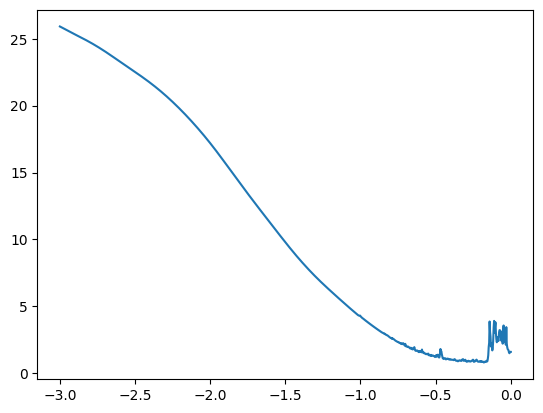

In [19]:
torch.manual_seed(13)
nn4_lr_test = MlpLM(3, 10, hidden_size=200)
lr_search(nn4_lr_test, xs_train[:1000], ys_train[:1000], steps=1001)

In [20]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.train(xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=256, steps=1001)

Model has 12530 parameters!
Using 293606 samples
Step 0 | loss: 26.3331 | val loss: 23.0984
Step 10 | loss: 14.6894 | val loss: 13.0895
Step 20 | loss: 10.3483 | val loss: 10.0103
Step 30 | loss: 8.6120 | val loss: 8.4581
Step 40 | loss: 8.0272 | val loss: 7.2324
Step 50 | loss: 7.4407 | val loss: 6.8579
Step 60 | loss: 6.7847 | val loss: 6.6777
Step 70 | loss: 6.3855 | val loss: 6.4581
Step 80 | loss: 6.2486 | val loss: 6.2981
Step 90 | loss: 6.1522 | val loss: 5.7037
Step 100 | loss: 5.3599 | val loss: 5.6929
Step 110 | loss: 5.2031 | val loss: 4.9981
Step 120 | loss: 4.2989 | val loss: 4.8622
Step 130 | loss: 4.8697 | val loss: 4.6223
Step 140 | loss: 4.5445 | val loss: 4.5604
Step 150 | loss: 4.7428 | val loss: 4.9416
Step 160 | loss: 4.4430 | val loss: 4.7687
Step 170 | loss: 4.4489 | val loss: 4.2711
Step 180 | loss: 4.1024 | val loss: 4.4107
Step 190 | loss: 3.8791 | val loss: 4.7344
Step 200 | loss: 5.6493 | val loss: 5.9361
Step 210 | loss: 3.9814 | val loss: 4.1894
Step 220 |

In [21]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.train(xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=256, steps=1001)

Model has 12530 parameters!
Using 293606 samples
Step 0 | loss: 26.3331 | val loss: 23.0984
Step 10 | loss: 14.6894 | val loss: 13.0895
Step 20 | loss: 10.3483 | val loss: 10.0103
Step 30 | loss: 8.6120 | val loss: 8.4581
Step 40 | loss: 8.0272 | val loss: 7.2324
Step 50 | loss: 7.4407 | val loss: 6.8579
Step 60 | loss: 6.7847 | val loss: 6.6777
Step 70 | loss: 6.3855 | val loss: 6.4581
Step 80 | loss: 6.2486 | val loss: 6.2981
Step 90 | loss: 6.1522 | val loss: 5.7037
Step 100 | loss: 5.3599 | val loss: 5.6929
Step 110 | loss: 5.2031 | val loss: 4.9981
Step 120 | loss: 4.2989 | val loss: 4.8622
Step 130 | loss: 4.8697 | val loss: 4.6223
Step 140 | loss: 4.5445 | val loss: 4.5604
Step 150 | loss: 4.7428 | val loss: 4.9416
Step 160 | loss: 4.4430 | val loss: 4.7687
Step 170 | loss: 4.4489 | val loss: 4.2711
Step 180 | loss: 4.1024 | val loss: 4.4107
Step 190 | loss: 3.8791 | val loss: 4.7344
Step 200 | loss: 5.6493 | val loss: 5.9361
Step 210 | loss: 3.9814 | val loss: 4.1894
Step 220 |

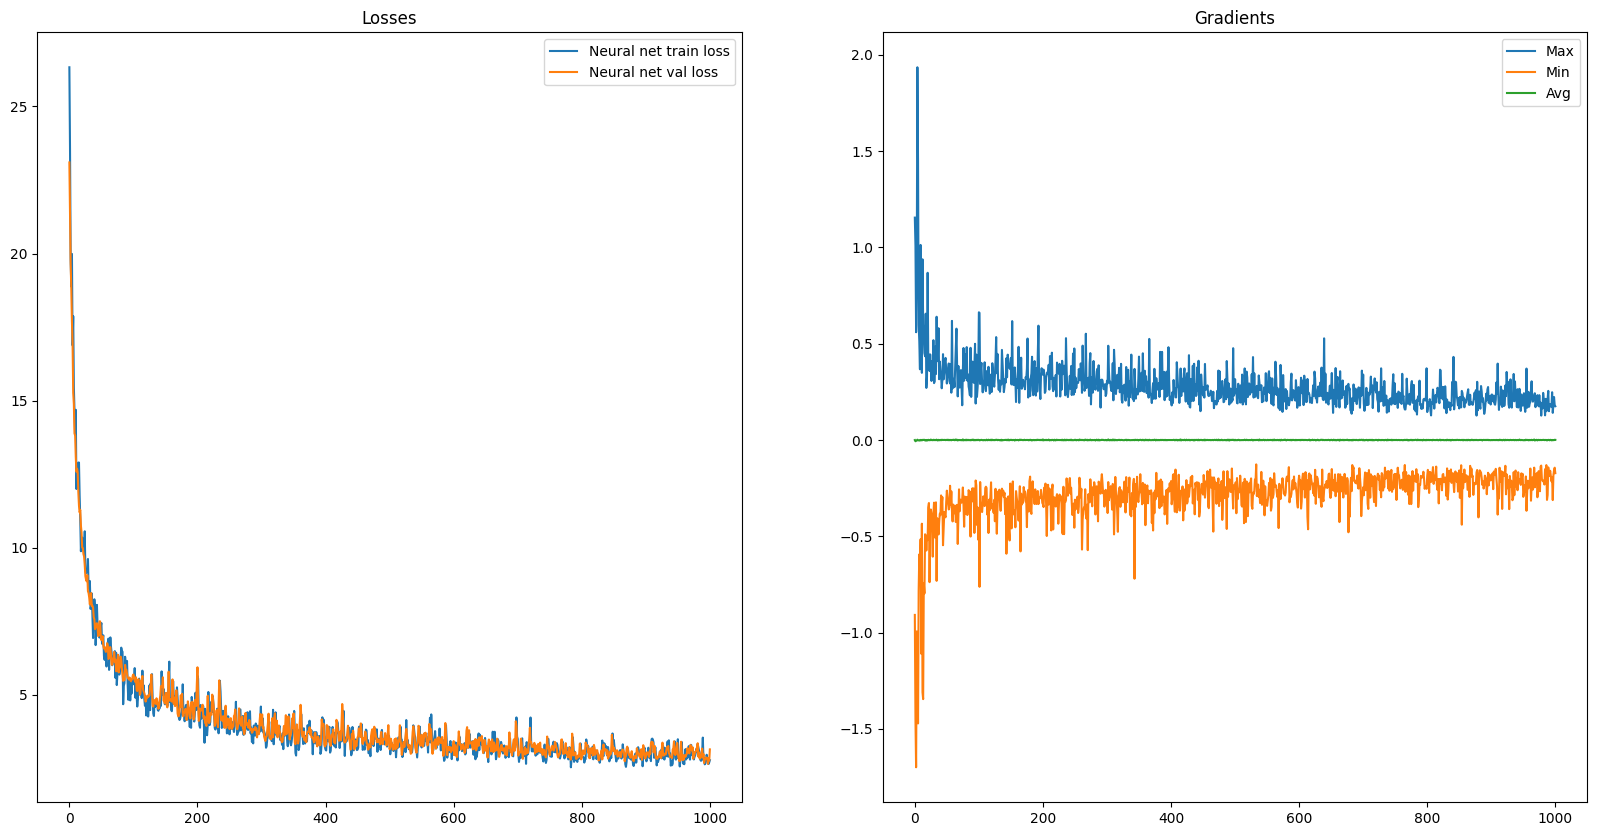

In [22]:
plot_training_loss(nn4)

In [23]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.train(xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=1024, steps=1001)

Model has 12530 parameters!
Using 293606 samples
Step 0 | loss: 26.3676 | val loss: 22.8161
Step 10 | loss: 12.9999 | val loss: 12.8720
Step 20 | loss: 9.7174 | val loss: 9.4078
Step 30 | loss: 7.6011 | val loss: 7.7231
Step 40 | loss: 7.1149 | val loss: 7.1474
Step 50 | loss: 6.3638 | val loss: 6.2986
Step 60 | loss: 5.9308 | val loss: 5.8794
Step 70 | loss: 5.8103 | val loss: 5.6047
Step 80 | loss: 5.4094 | val loss: 5.3839
Step 90 | loss: 4.7887 | val loss: 5.1377
Step 100 | loss: 4.7872 | val loss: 5.3037
Step 110 | loss: 4.7685 | val loss: 4.7834
Step 120 | loss: 4.9344 | val loss: 4.9813
Step 130 | loss: 4.5978 | val loss: 4.6708
Step 140 | loss: 4.6262 | val loss: 4.5446
Step 150 | loss: 4.7532 | val loss: 4.3582
Step 160 | loss: 4.4068 | val loss: 4.4783
Step 170 | loss: 4.4166 | val loss: 4.4298
Step 180 | loss: 3.9064 | val loss: 3.9520
Step 190 | loss: 3.9779 | val loss: 4.1378
Step 200 | loss: 4.1971 | val loss: 3.8986
Step 210 | loss: 3.9583 | val loss: 4.4517
Step 220 | l

In [24]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.train(xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=1024, steps=1001)

Model has 12530 parameters!
Using 293606 samples
Step 0 | loss: 26.3676 | val loss: 22.8161
Step 10 | loss: 12.9999 | val loss: 12.8720
Step 20 | loss: 9.7174 | val loss: 9.4078
Step 30 | loss: 7.6011 | val loss: 7.7231
Step 40 | loss: 7.1149 | val loss: 7.1474
Step 50 | loss: 6.3638 | val loss: 6.2986
Step 60 | loss: 5.9308 | val loss: 5.8794
Step 70 | loss: 5.8103 | val loss: 5.6047
Step 80 | loss: 5.4094 | val loss: 5.3839
Step 90 | loss: 4.7887 | val loss: 5.1377
Step 100 | loss: 4.7872 | val loss: 5.3037
Step 110 | loss: 4.7685 | val loss: 4.7834
Step 120 | loss: 4.9344 | val loss: 4.9813
Step 130 | loss: 4.5978 | val loss: 4.6708
Step 140 | loss: 4.6262 | val loss: 4.5446
Step 150 | loss: 4.7532 | val loss: 4.3582
Step 160 | loss: 4.4068 | val loss: 4.4783
Step 170 | loss: 4.4166 | val loss: 4.4298
Step 180 | loss: 3.9064 | val loss: 3.9520
Step 190 | loss: 3.9779 | val loss: 4.1378
Step 200 | loss: 4.1971 | val loss: 3.8986
Step 210 | loss: 3.9583 | val loss: 4.4517
Step 220 | l

In [25]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.train(xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=1024, steps=1001)

Model has 12530 parameters!
Using 293606 samples
Step 0 | loss: 26.3676 | val loss: 22.8161
Step 10 | loss: 12.9999 | val loss: 12.8720
Step 20 | loss: 9.7174 | val loss: 9.4078
Step 30 | loss: 7.6011 | val loss: 7.7231
Step 40 | loss: 7.1149 | val loss: 7.1474
Step 50 | loss: 6.3638 | val loss: 6.2986
Step 60 | loss: 5.9308 | val loss: 5.8794
Step 70 | loss: 5.8103 | val loss: 5.6047
Step 80 | loss: 5.4094 | val loss: 5.3839
Step 90 | loss: 4.7887 | val loss: 5.1377
Step 100 | loss: 4.7872 | val loss: 5.3037
Step 110 | loss: 4.7685 | val loss: 4.7834
Step 120 | loss: 4.9344 | val loss: 4.9813
Step 130 | loss: 4.5978 | val loss: 4.6708
Step 140 | loss: 4.6262 | val loss: 4.5446
Step 150 | loss: 4.7532 | val loss: 4.3582
Step 160 | loss: 4.4068 | val loss: 4.4783
Step 170 | loss: 4.4166 | val loss: 4.4298
Step 180 | loss: 3.9064 | val loss: 3.9520
Step 190 | loss: 3.9779 | val loss: 4.1378
Step 200 | loss: 4.1971 | val loss: 3.8986
Step 210 | loss: 3.9583 | val loss: 4.4517
Step 220 | l

In [26]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.train(xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=1024, steps=1001)

Model has 12530 parameters!
Using 293606 samples
Step 0 | loss: 26.3676 | val loss: 22.8161
Step 10 | loss: 12.9999 | val loss: 12.8720
Step 20 | loss: 9.7174 | val loss: 9.4078
Step 30 | loss: 7.6011 | val loss: 7.7231
Step 40 | loss: 7.1149 | val loss: 7.1474
Step 50 | loss: 6.3638 | val loss: 6.2986
Step 60 | loss: 5.9308 | val loss: 5.8794
Step 70 | loss: 5.8103 | val loss: 5.6047
Step 80 | loss: 5.4094 | val loss: 5.3839
Step 90 | loss: 4.7887 | val loss: 5.1377
Step 100 | loss: 4.7872 | val loss: 5.3037
Step 110 | loss: 4.7685 | val loss: 4.7834
Step 120 | loss: 4.9344 | val loss: 4.9813
Step 130 | loss: 4.5978 | val loss: 4.6708
Step 140 | loss: 4.6262 | val loss: 4.5446
Step 150 | loss: 4.7532 | val loss: 4.3582
Step 160 | loss: 4.4068 | val loss: 4.4783
Step 170 | loss: 4.4166 | val loss: 4.4298
Step 180 | loss: 3.9064 | val loss: 3.9520
Step 190 | loss: 3.9779 | val loss: 4.1378
Step 200 | loss: 4.1971 | val loss: 3.8986
Step 210 | loss: 3.9583 | val loss: 4.4517
Step 220 | l

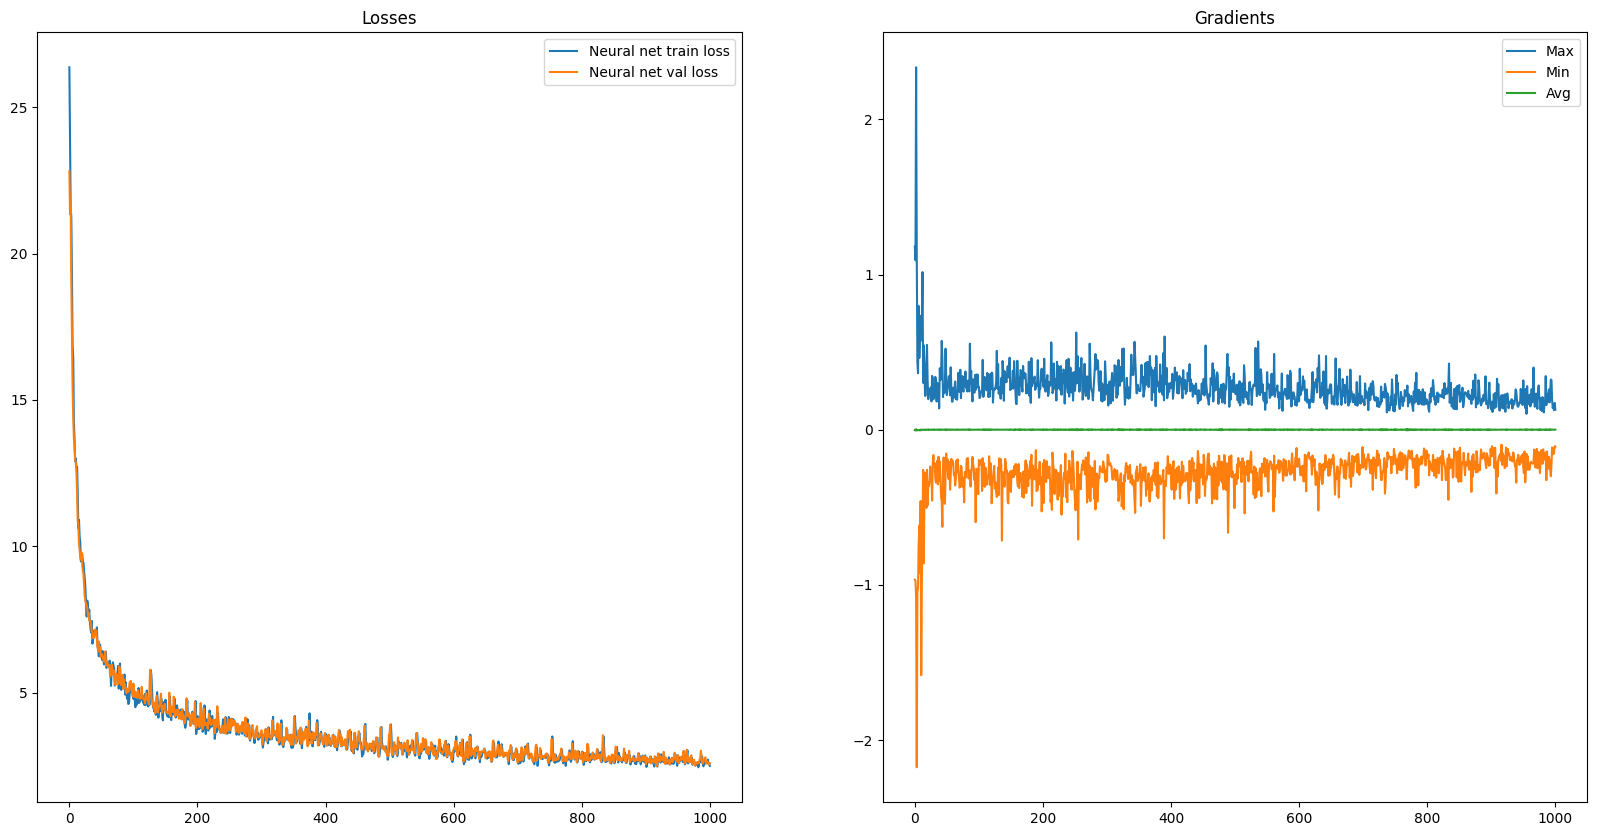

In [27]:
plot_training_loss(nn4)

In [28]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.train(xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=8192, steps=1001)

Model has 12530 parameters!
Using 293606 samples
Step 0 | loss: 26.1190 | val loss: 22.9988
Step 10 | loss: 13.7092 | val loss: 12.8082
Step 20 | loss: 9.8428 | val loss: 9.3426
Step 30 | loss: 7.7564 | val loss: 7.5794
Step 40 | loss: 6.6537 | val loss: 6.5617
Step 50 | loss: 5.9405 | val loss: 6.2450
Step 60 | loss: 5.5554 | val loss: 5.6134
Step 70 | loss: 5.2367 | val loss: 5.2167
Step 80 | loss: 4.9794 | val loss: 5.1445
Step 90 | loss: 4.6621 | val loss: 4.9896
Step 100 | loss: 4.3743 | val loss: 4.4509
Step 110 | loss: 4.5247 | val loss: 4.4736
Step 120 | loss: 4.4449 | val loss: 4.5600
Step 130 | loss: 4.4837 | val loss: 4.5188
Step 140 | loss: 4.1421 | val loss: 4.3278
Step 150 | loss: 4.3335 | val loss: 4.1930
Step 160 | loss: 4.2057 | val loss: 4.1635
Step 170 | loss: 4.4220 | val loss: 4.1201
Step 180 | loss: 3.7552 | val loss: 4.0917
Step 190 | loss: 3.8273 | val loss: 3.7403
Step 200 | loss: 3.7213 | val loss: 3.6873
Step 210 | loss: 3.6294 | val loss: 3.6986
Step 220 | l

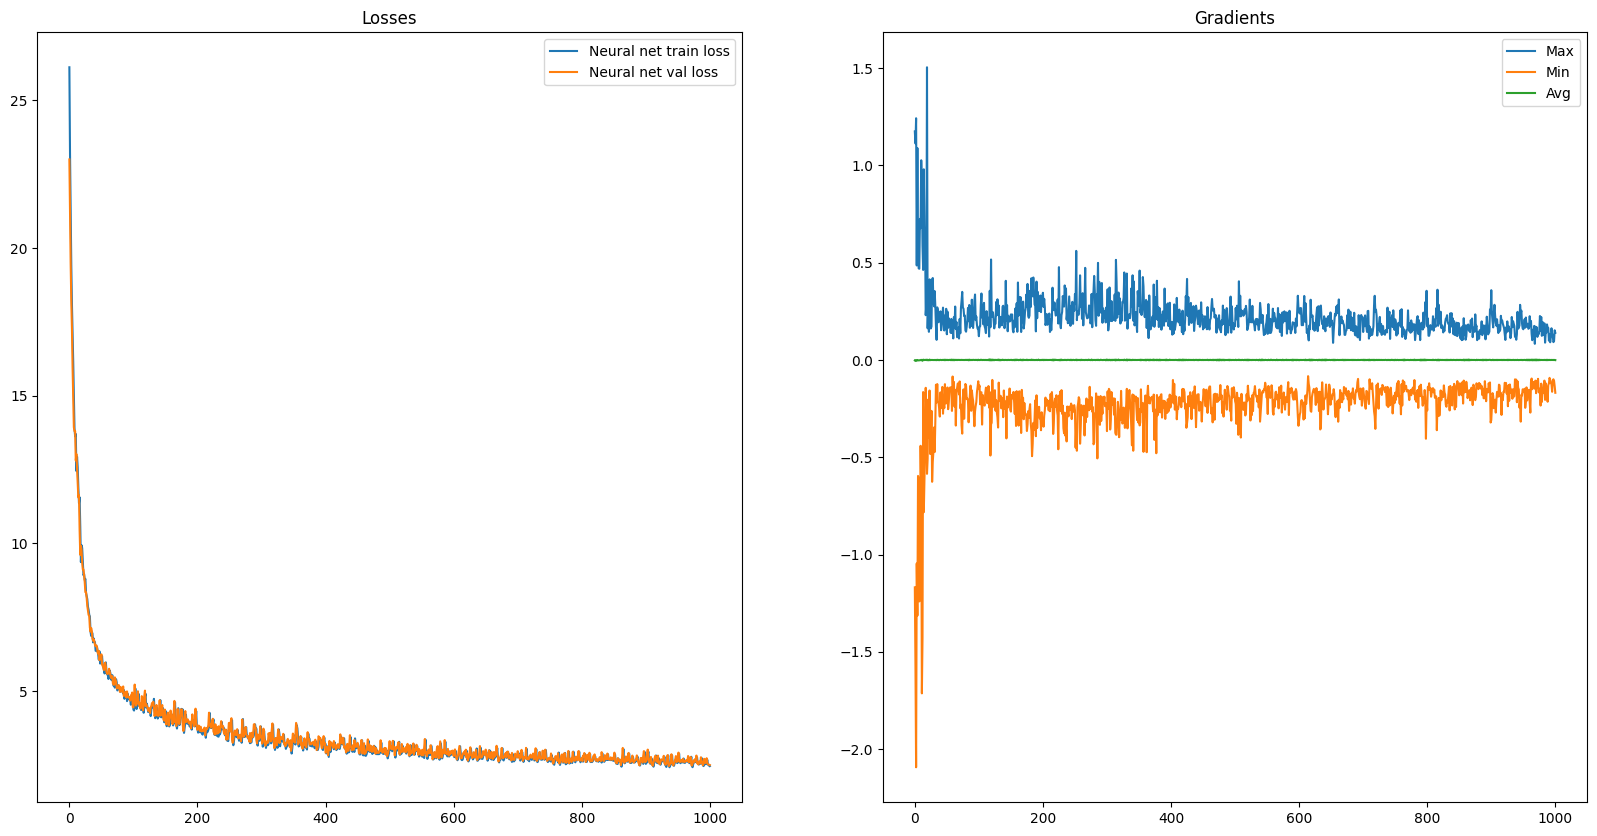

In [29]:
plot_training_loss(nn4)

In [30]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.train(xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=None, steps=1001)

Model has 12530 parameters!
Using 293606 samples
Step 0 | loss: 26.1091 | val loss: 23.2980
Step 10 | loss: 12.8254 | val loss: 12.7734
Step 20 | loss: 9.2633 | val loss: 8.8566
Step 30 | loss: 7.5457 | val loss: 7.3096
Step 40 | loss: 6.6454 | val loss: 6.7175
Step 50 | loss: 5.9471 | val loss: 6.1408
Step 60 | loss: 5.5987 | val loss: 5.6858
Step 70 | loss: 5.4462 | val loss: 5.7174
Step 80 | loss: 5.3738 | val loss: 5.1155
Step 90 | loss: 4.7339 | val loss: 4.9495
Step 100 | loss: 4.6903 | val loss: 4.8158
Step 110 | loss: 4.4957 | val loss: 4.8652
Step 120 | loss: 4.3384 | val loss: 4.4154
Step 130 | loss: 4.3457 | val loss: 4.4788
Step 140 | loss: 4.1967 | val loss: 4.0798
Step 150 | loss: 4.1606 | val loss: 4.3664
Step 160 | loss: 4.0011 | val loss: 4.3018
Step 170 | loss: 3.8780 | val loss: 4.0679
Step 180 | loss: 3.7677 | val loss: 4.1579
Step 190 | loss: 3.8905 | val loss: 3.8009
Step 200 | loss: 3.6538 | val loss: 3.8344
Step 210 | loss: 3.6316 | val loss: 3.5179
Step 220 | l

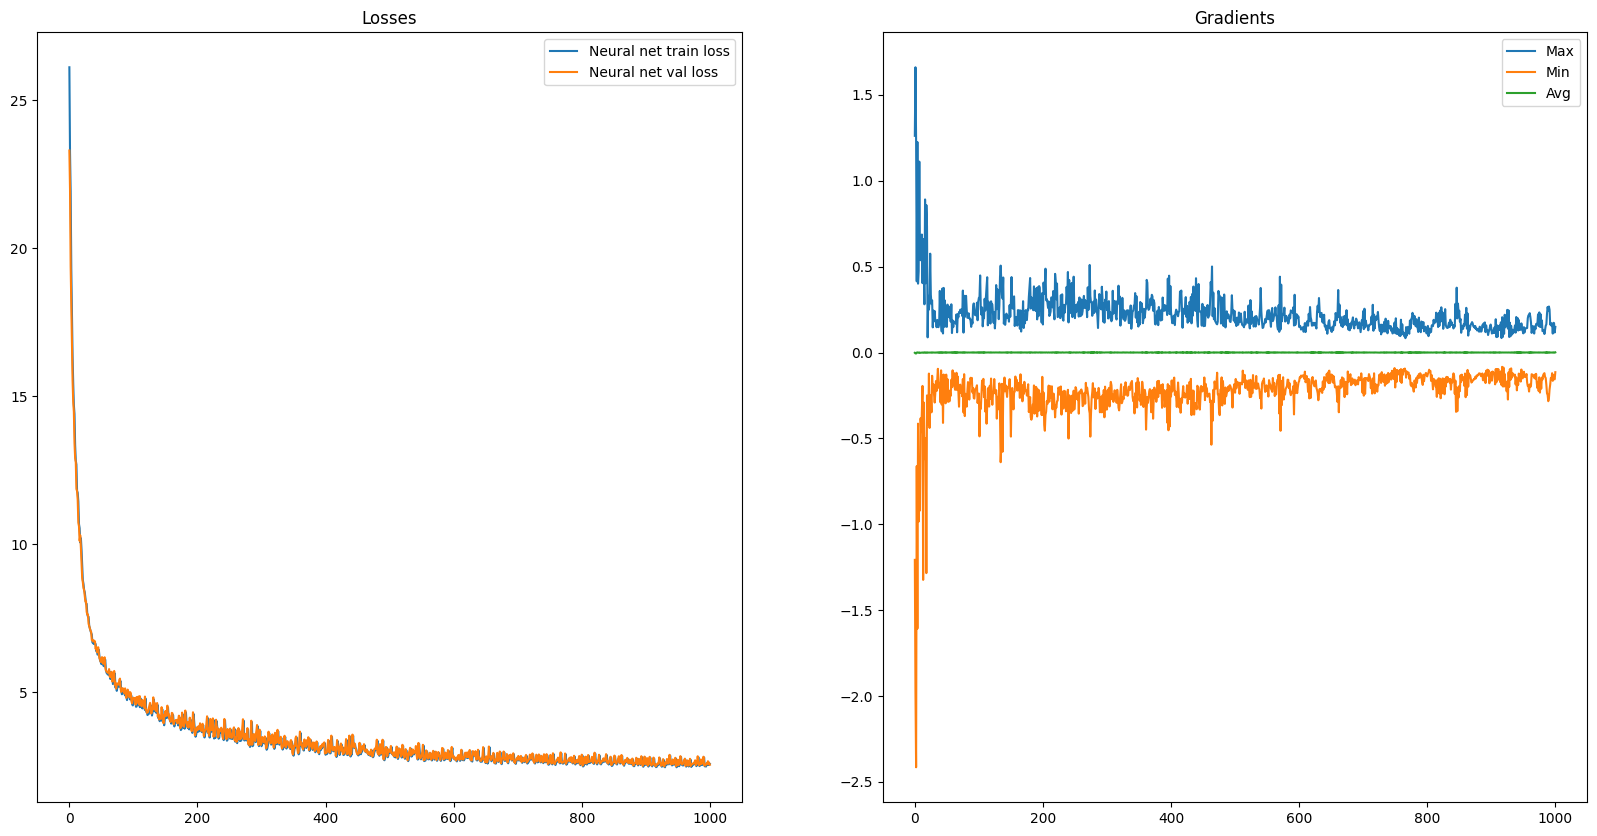

In [31]:
plot_training_loss(nn4)